# Atom Selection and Substructure Matching

This notebook demonstrates the atom selection and substructure matching capabilities in molify. The package provides a unified approach with advanced features:

- **`match_substructure`**: Pattern matching with RDKit Mol objects supporting SMILES/SMARTS patterns, hydrogen handling, and atom mapping
- **`group_matches_by_fragment`**: Helper function to organize matches by disconnected molecular fragments

The examples progress from simple pattern matching to advanced selection techniques with precise control over atom ordering and hydrogen inclusion.

**Key Principle:** Conversions from ASE Atoms to RDKit Mol are explicit using `ase2rdkit(atoms, suggestions=[...])`, giving you full control over bond detection.

In [1]:
from rdkit.Chem import CombineMols, Draw

import molify

## Basic Substructure Matching with `match_substructure`

The `match_substructure` function provides pattern matching in molecular structures using RDKit Mol objects. It supports SMILES and SMARTS patterns and returns all matches as tuples of atom indices.

The function requires explicit conversion from ASE Atoms to RDKit Mol using `ase2rdkit()`, which allows you to control bond detection through the `suggestions` parameter.

Ethanol has 9 atoms
Chemical formula: C2H6O


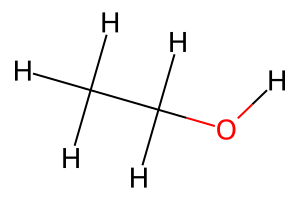

In [2]:
# Create an ethanol molecule for basic examples
ethanol = molify.smiles2atoms("CCO")
print(f"Ethanol has {len(ethanol)} atoms")
print(f"Chemical formula: {ethanol.get_chemical_formula()}")

# Convert to RDKit Mol for substructure matching
ethanol_mol = molify.ase2rdkit(ethanol, suggestions=["CCO"])

# Visualize the structure
Draw.MolToImage(ethanol_mol, size=(300, 200))

In [3]:
# Match carbon atoms using SMARTS pattern
carbon_matches = molify.match_substructure(ethanol_mol, "[#6]")
print(f"Carbon atom matches: {carbon_matches}")
print(f"Number of carbon matches: {len(carbon_matches)}")

# Match the hydroxyl oxygen
hydroxyl_matches = molify.match_substructure(ethanol_mol, "[#8]")
print(f"\nHydroxyl oxygen matches: {hydroxyl_matches}")

Carbon atom matches: ((0,), (1,))
Number of carbon matches: 2

Hydroxyl oxygen matches: ((2,),)


In [4]:
# Use SMARTS for more specific pattern matching
# Match only sp3 carbon atoms (aliphatic carbons with single bonds)
sp3_carbons = molify.match_substructure(ethanol_mol, "[C;X4]")
print(f"sp3 carbon matches: {sp3_carbons}")

# Match oxygen with exactly one hydrogen (hydroxyl group)
hydroxyl_oxygen = molify.match_substructure(ethanol_mol, "[OH1]")
print(f"Hydroxyl oxygen: {hydroxyl_oxygen}")

sp3 carbon matches: ((0,), (1,))
Hydroxyl oxygen: ((2,),)


### Multiple Matches in Complex Molecules

When a pattern occurs multiple times in a molecule, `match_substructure` returns all matches as a tuple of tuples, where each inner tuple contains the atom indices for one match.

All carbon matches in propanol: ((0,), (1,), (2,))
Total carbon atoms found: 3

C-C-O pattern matches: ((1, 2, 3),)


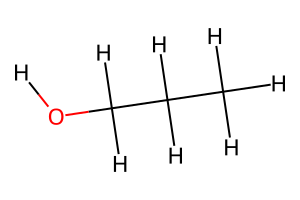

In [5]:
# Create propanol with multiple carbon atoms
propanol = molify.smiles2atoms("CCCO")
propanol_mol = molify.ase2rdkit(propanol, suggestions=["CCCO"])

# Find all carbon atoms
carbon_matches = molify.match_substructure(propanol_mol, "[#6]")
print(f"All carbon matches in propanol: {carbon_matches}")
print(f"Total carbon atoms found: {len(carbon_matches)}")

# Find the C-C-O pattern
cco_pattern = molify.match_substructure(propanol_mol, "CCO")
print(f"\nC-C-O pattern matches: {cco_pattern}")

# Visualize
Draw.MolToImage(propanol_mol, size=(300, 200))

## Advanced Features: Hydrogen Handling and Atom Mapping

The `match_substructure` function provides advanced capabilities beyond basic pattern matching:

- **Hydrogen handling**: Three modes (exclude, include, isolated) for precise control over hydrogen inclusion
- **Atom mapping**: Support for mapped SMILES patterns with guaranteed atom ordering  
- **Fragment grouping**: Use `group_matches_by_fragment` helper to organize matches by disconnected molecular fragments

These features are particularly useful in molecular dynamics simulations and quantum chemical calculations where explicit hydrogen control and fragment-aware operations are required.

### Hydrogen Handling Modes

The function provides three modes for controlling hydrogen atom inclusion in matches:

- **`exclude`** (default): Returns only heavy atoms, excluding all hydrogens
- **`include`**: Returns heavy atoms followed by their bonded hydrogens
- **`isolated`**: Returns only the hydrogen atoms bonded to matched heavy atoms

This capability is particularly useful in molecular dynamics simulations and quantum chemical calculations where explicit hydrogen control is required.

In [6]:
# Select the C-O bond pattern with different hydrogen handling
pattern = "CO"  # Carbon-Oxygen bond

# Default: exclude hydrogens
exclude_h = molify.match_substructure(ethanol_mol, pattern, hydrogens="exclude")
print(f"Exclude hydrogens: {exclude_h}")

# Include hydrogens attached to matched heavy atoms
include_h = molify.match_substructure(ethanol_mol, pattern, hydrogens="include")
print(f"Include hydrogens: {include_h}")

# Return only the hydrogens attached to matched heavy atoms
isolated_h = molify.match_substructure(ethanol_mol, pattern, hydrogens="isolated")
print(f"Isolated hydrogens: {isolated_h}")

Exclude hydrogens: ((1, 2),)
Include hydrogens: ((1, 6, 7, 2, 8),)
Isolated hydrogens: ((6, 7, 8),)


### Fragment-Aware Grouping

When working with molecules containing multiple disconnected fragments, use `group_matches_by_fragment` to organize matches by fragment. This helper function takes the raw matches from `match_substructure` and groups them by which disconnected fragment they belong to.

In [7]:
# Combine two ethanol molecules into a single Mol object
multi_fragment_mol = CombineMols(ethanol_mol, ethanol_mol)

# Select carbon atoms - get all matches first
carbon_matches = molify.match_substructure(multi_fragment_mol, "[#6]")
print(f"All carbon matches: {carbon_matches}")

# Group by fragment
carbon_indices = molify.group_matches_by_fragment(multi_fragment_mol, carbon_matches)
print(f"Carbon indices grouped by fragment: {carbon_indices}")
print(f"Fragment 1 carbons: {carbon_indices[0]}")
print(f"Fragment 2 carbons: {carbon_indices[1]}")

All carbon matches: ((0,), (1,), (9,), (10,))
Carbon indices grouped by fragment: [[0, 1], [9, 10]]
Fragment 1 carbons: [0, 1]
Fragment 2 carbons: [9, 10]


### Mapped SMILES Patterns and Atom Ordering

Mapped SMILES patterns provide precise control over which atoms are selected and their ordering in the output. When atom map numbers are specified (e.g., `[C:1]`, `[C:2]`) and `mapped_only=True` is used, only the mapped atoms are returned, ordered by their map numbers in ascending order.

This feature enables deterministic atom ordering for applications requiring specific atom sequences, such as distance measurements, dihedral angle calculations, or constraint definitions in molecular simulations.

In [8]:
# Using mapped SMILES to select only specific atoms
# This pattern matches the carbon-carbon-oxygen chain,
# but with mapped_only=True, only returns the mapped carbons
mapped_pattern = "[C:1][C:2]O"
mapped_indices = molify.match_substructure(
    ethanol_mol, mapped_pattern, mapped_only=True
)
print(f"Mapped carbon indices: {mapped_indices}")

# Compare with mapped_only=False which returns all matched atoms
unmapped_indices = molify.match_substructure(
    ethanol_mol, mapped_pattern, mapped_only=False
)
print(f"All matched atoms: {unmapped_indices}")

# Demonstrate atom ordering control with alanine dipeptide
aladip = molify.smiles2atoms("CC(=O)NC(C)C(=O)NC")
aladip_mol = molify.ase2rdkit(aladip, suggestions=["CC(=O)NC(C)C(=O)NC"])

# Select atoms in map order 1, 2, 3, 4
indices_1234 = molify.match_substructure(
    aladip_mol, "CC(=O)N[C:1]([C:2])[C:3](=O)[N:4]C", mapped_only=True
)
print(f"\nMap order 1,2,3,4: {indices_1234}")

# Select the same atoms but in different map order 4, 3, 2, 1
indices_4321 = molify.match_substructure(
    aladip_mol, "CC(=O)N[C:4]([C:3])[C:2](=O)[N:1]C", mapped_only=True
)
print(f"Map order 4,3,2,1: {indices_4321}")

Mapped carbon indices: ((0, 1),)
All matched atoms: ((0, 1, 2),)

Map order 1,2,3,4: ((4, 5, 6, 8),)
Map order 4,3,2,1: ((8, 6, 5, 4),)


### Visualization of Atom Selections

The `visualize_selected_molecules` function provides visual feedback for atom selections by highlighting selected atoms in molecular structure depictions. Multiple selection sets can be simultaneously visualized with distinct color coding, facilitating comparison and validation of selection patterns.

When using with `match_substructure`, you'll need to flatten the matches into a simple list of indices for visualization.

Aromatic carbons: ((1,), (2,), (3,), (4,), (5,), (6,))
Methyl carbon: ((0,),)


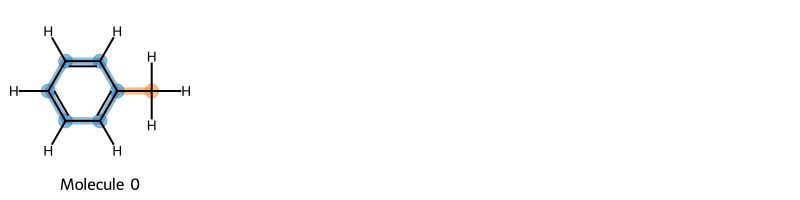

In [9]:
# Create toluene molecule for visualization examples
toluene_smiles = "Cc1ccccc1"
toluene_mol = molify.ase2rdkit(
    molify.smiles2atoms(toluene_smiles), suggestions=["Cc1ccccc1"]
)

# Select different atom types
aromatic_carbons = molify.match_substructure(toluene_mol, "c", hydrogens="exclude")
methyl_carbon = molify.match_substructure(toluene_mol, "[C;!c]", hydrogens="exclude")

print(f"Aromatic carbons: {aromatic_carbons}")
print(f"Methyl carbon: {methyl_carbon}")

# Flatten matches for visualization
aromatic_flat = [idx for match in aromatic_carbons for idx in match]
methyl_flat = [idx for match in methyl_carbon for idx in match]

# Visualize with highlighted selections
img = molify.visualize_selected_molecules(toluene_mol, aromatic_flat, methyl_flat)
img

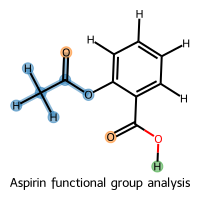

In [10]:
# Aspirin (acetylsalicylic acid) contains multiple functional groups
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"
aspirin_mol = molify.ase2rdkit(
    molify.smiles2atoms(aspirin_smiles), suggestions=[aspirin_smiles]
)

# Select different functional groups
# Acetyl ester group with hydrogens (using mapped_only to get specific atoms)
acetyl = molify.match_substructure(
    aspirin_mol,
    "[C:1][C:2](=O)[O:4]c1ccccc1C(=O)O",
    hydrogens="include",
    mapped_only=True,
)

# Carbonyl oxygens
carbonyls = molify.match_substructure(aspirin_mol, "[O:1]=C", mapped_only=True)

# Carboxylic acid hydrogens
acid_h = molify.match_substructure(aspirin_mol, "CO", hydrogens="isolated")

# Flatten for visualization
acetyl_flat = [idx for match in acetyl for idx in match]
carbonyls_flat = [idx for match in carbonyls for idx in match]
acid_h_flat = [idx for match in acid_h for idx in match]

# Visualize with multiple functional group highlights
molify.visualize_selected_molecules(
    aspirin_mol,
    acetyl_flat,
    carbonyls_flat,
    acid_h_flat,
    mols_per_row=1,
    legends=["Aspirin functional group analysis"],
)